In [ ]:
from google.colab import drive 
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
import sys
rbf_module = '/content/gdrive/MyDrive/Thesis_Reg/rbf_for_tf2'
datafolder = '/content/gdrive/MyDrive/Thesis_Reg/Dataset'
sys.path.append(rbf_module)
sys.path.append(datafolder)

In [ ]:
import pandas as pd 
import os 
import seaborn as sns 
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kmeans_initializer ### Cloned from Github Repo !git clone https://github.com/PetraVidnerova/rbf_for_tf2
import rbflayer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2, l1_l2

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
np.random.seed(42)

In [ ]:
df_ = pd.read_csv(os.path.join(datafolder, 'Data.csv'), delimiter=',')
df_.head()

,Z1D1,Z2D1,aZ1D1,aZ2D1,Z1D2,Z2D2,aZ1D2,aZ2D2,Z1D3,Z2D3,aZ1D3,aZ2D3,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,Throughput,Costs
0,1,3,2,3,1,1,3,2,3,3,2,2,3,2,3,3,4,1,4,4,3,3,3,4,2436,3640
1,2,2,3,1,1,2,2,2,3,3,1,2,3,2,5,5,4,3,1,4,2,2,4,4,2490,3360
2,2,3,2,2,1,1,2,2,2,1,2,2,4,2,4,3,5,2,4,2,1,3,1,4,2028,3080
3,1,3,3,3,1,3,2,3,2,3,2,1,1,1,1,4,2,2,5,2,5,2,3,4,3021,3780
4,2,1,1,3,2,2,2,1,1,1,3,1,3,3,4,2,1,3,2,3,5,1,2,4,1247,2800


In [ ]:
df_.describe()

,Z1D1,Z2D1,aZ1D1,aZ2D1,Z1D2,Z2D2,aZ1D2,aZ2D2,Z1D3,Z2D3,aZ1D3,aZ2D3,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,Throughput,Costs
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,2.001529,1.999059,1.998353,1.999529,2.001118,1.996353,2.001059,1.994471,2.001706,1.998471,1.999294,2.008471,3.007765,3.008706,2.997000,3.009294,3.000471,3.005765,3.005176,2.990471,2.997059,3.007118,3.008353,3.004706,2275.735529,3359.917647
std,0.705293,0.707293,0.705460,0.707294,0.708166,0.704868,0.704960,0.706940,0.713379,0.709617,0.705712,0.707991,1.221438,1.228730,1.224273,1.228151,1.219341,1.228412,1.214157,1.215341,1.227752,1.224448,1.223695,1.218560,470.379462,342.080220
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,968.000000,1960.000000
25%,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1942.000000,3080.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2269.000000,3360.000000
75%,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2604.250000,3640.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3644.000000,4620.000000


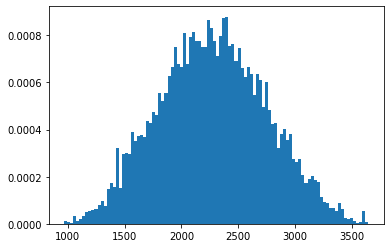

In [ ]:
plt.hist(df_['Throughput'], bins=100, density=True)
plt.show()

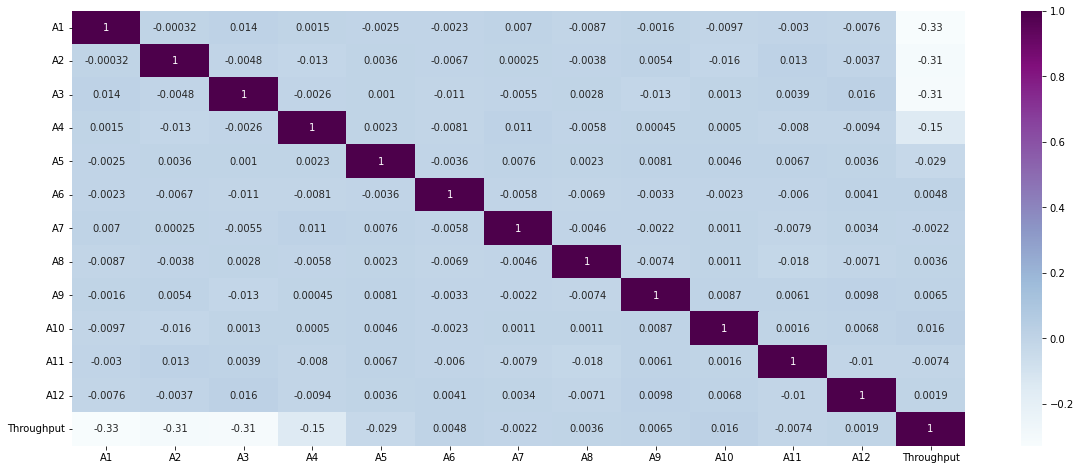

In [ ]:
plt.figure(figsize=(20,8))
cor = df_[['A1', 'A2', 'A3', 'A4', 'A5', 'A6',
       'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'Throughput']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.BuPu)
plt.show()

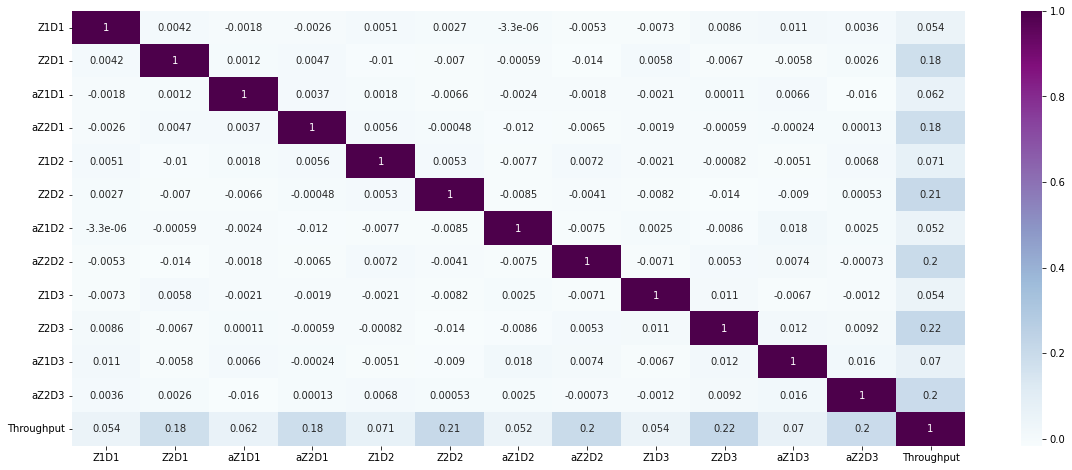

In [ ]:
plt.figure(figsize=(20,8))
cor = df_[['Z1D1', 'Z2D1', 'aZ1D1', 'aZ2D1', 'Z1D2', 'Z2D2', 'aZ1D2', 'aZ2D2',
       'Z1D3', 'Z2D3', 'aZ1D3', 'aZ2D3','Throughput']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.BuPu)
plt.show()

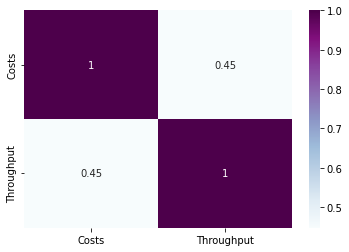

In [ ]:
cor = df_[['Costs','Throughput']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.BuPu)
plt.show()

In [ ]:
# Generate dummies for categorical columns from A1 to A12 
cat_col =['A1','A2', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A12']
df = df_.copy()
for i in cat_col:
  df = pd.concat([df,pd.get_dummies(df[i],prefix=i)],axis=1)
  df.drop(i, axis=1, inplace=True)
df.head()

,Z1D1,Z2D1,aZ1D1,aZ2D1,Z1D2,Z2D2,aZ1D2,aZ2D2,Z1D3,Z2D3,aZ1D3,aZ2D3,Throughput,Costs,A1_1,A1_2,A1_3,A1_4,A1_5,A2_1,A2_2,A2_3,A2_4,A2_5,A3_1,A3_2,A3_3,A3_4,A3_5,A4_1,A4_2,A4_3,A4_4,A4_5,A5_1,A5_2,A5_3,A5_4,A5_5,A6_1,A6_2,A6_3,A6_4,A6_5,A7_1,A7_2,A7_3,A7_4,A7_5,A8_1,A8_2,A8_3,A8_4,A8_5,A9_1,A9_2,A9_3,A9_4,A9_5,A10_1,A10_2,A10_3,A10_4,A10_5,A11_1,A11_2,A11_3,A11_4,A11_5,A12_1,A12_2,A12_3,A12_4,A12_5
0,1,3,2,3,1,1,3,2,3,3,2,2,2436,3640,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,2,2,3,1,1,2,2,2,3,3,1,2,2490,3360,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2,3,2,2,1,1,2,2,2,1,2,2,2028,3080,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,1,3,3,3,1,3,2,3,2,3,2,1,3021,3780,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2,1,1,3,2,2,2,1,1,1,3,1,1247,2800,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
df['Throughput'] = zscore(df['Throughput'])
df.head()

,Z1D1,Z2D1,aZ1D1,aZ2D1,Z1D2,Z2D2,aZ1D2,aZ2D2,Z1D3,Z2D3,aZ1D3,aZ2D3,Throughput,Costs,A1_1,A1_2,A1_3,A1_4,A1_5,A2_1,A2_2,A2_3,A2_4,A2_5,A3_1,A3_2,A3_3,A3_4,A3_5,A4_1,A4_2,A4_3,A4_4,A4_5,A5_1,A5_2,A5_3,A5_4,A5_5,A6_1,A6_2,A6_3,A6_4,A6_5,A7_1,A7_2,A7_3,A7_4,A7_5,A8_1,A8_2,A8_3,A8_4,A8_5,A9_1,A9_2,A9_3,A9_4,A9_5,A10_1,A10_2,A10_3,A10_4,A10_5,A11_1,A11_2,A11_3,A11_4,A11_5,A12_1,A12_2,A12_3,A12_4,A12_5
0,1,3,2,3,1,1,3,2,3,3,2,2,0.340723,3640,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,2,2,3,1,1,2,2,2,3,3,1,2,0.455527,3360,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2,3,2,2,1,1,2,2,2,1,2,2,-0.526687,3080,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,1,3,3,3,1,3,2,3,2,3,2,1,1.584437,3780,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2,1,1,3,2,2,2,1,1,1,3,1,-2.187098,2800,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
df.drop('Costs', axis=1, inplace=True)
df.head()

,Z1D1,Z2D1,aZ1D1,aZ2D1,Z1D2,Z2D2,aZ1D2,aZ2D2,Z1D3,Z2D3,aZ1D3,aZ2D3,Throughput,A1_1,A1_2,A1_3,A1_4,A1_5,A2_1,A2_2,A2_3,A2_4,A2_5,A3_1,A3_2,A3_3,A3_4,A3_5,A4_1,A4_2,A4_3,A4_4,A4_5,A5_1,A5_2,A5_3,A5_4,A5_5,A6_1,A6_2,A6_3,A6_4,A6_5,A7_1,A7_2,A7_3,A7_4,A7_5,A8_1,A8_2,A8_3,A8_4,A8_5,A9_1,A9_2,A9_3,A9_4,A9_5,A10_1,A10_2,A10_3,A10_4,A10_5,A11_1,A11_2,A11_3,A11_4,A11_5,A12_1,A12_2,A12_3,A12_4,A12_5
0,1,3,2,3,1,1,3,2,3,3,2,2,0.340723,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,2,2,3,1,1,2,2,2,3,3,1,2,0.455527,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2,3,2,2,1,1,2,2,2,1,2,2,-0.526687,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,1,3,3,3,1,3,2,3,2,3,2,1,1.584437,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2,1,1,3,2,2,2,1,1,1,3,1,-2.187098,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
df.describe()

,Z1D1,Z2D1,aZ1D1,aZ2D1,Z1D2,Z2D2,aZ1D2,aZ2D2,Z1D3,Z2D3,aZ1D3,aZ2D3,Throughput,A1_1,A1_2,A1_3,A1_4,A1_5,A2_1,A2_2,A2_3,A2_4,A2_5,A3_1,A3_2,A3_3,A3_4,A3_5,A4_1,A4_2,A4_3,A4_4,A4_5,A5_1,A5_2,A5_3,A5_4,A5_5,A6_1,A6_2,A6_3,A6_4,A6_5,A7_1,A7_2,A7_3,A7_4,A7_5,A8_1,A8_2,A8_3,A8_4,A8_5,A9_1,A9_2,A9_3,A9_4,A9_5,A10_1,A10_2,A10_3,A10_4,A10_5,A11_1,A11_2,A11_3,A11_4,A11_5,A12_1,A12_2,A12_3,A12_4,A12_5
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,1.700000e+04,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,2.001529,1.999059,1.998353,1.999529,2.001118,1.996353,2.001059,1.994471,2.001706,1.998471,1.999294,2.008471,7.394902e-17,0.122118,0.249882,0.251941,0.250235,0.125824,0.124529,0.249647,0.245706,0.252824,0.127294,0.125647,0.249706,0.250882,0.249529,0.124235,0.124000,0.248235,0.251529,0.246941,0.129294,0.123706,0.250000,0.250412,0.253882,0.122000,0.125529,0.249176,0.245118,0.254353,0.125824,0.122588,0.246471,0.254353,0.256353,0.120235,0.123882,0.252235,0.252824,0.251647,0.119412,0.126882,0.248882,0.250118,0.248529,0.125588,0.124588,0.245471,0.255000,0.248118,0.126824,0.122941,0.249471,0.250118,0.251235,0.126235,0.121294,0.251118,0.254235,0.248294,0.125059
std,0.705293,0.707293,0.705460,0.707294,0.708166,0.704868,0.704960,0.706940,0.713379,0.709617,0.705712,0.707991,1.000029e+00,0.327431,0.432957,0.434140,0.433161,0.331660,0.330194,0.432821,0.430518,0.434643,0.333312,0.331461,0.432855,0.433534,0.432753,0.329859,0.329591,0.432002,0.433905,0.431245,0.335535,0.329255,0.433025,0.433263,0.435244,0.327295,0.331328,0.432549,0.430170,0.435510,0.331660,0.327974,0.430968,0.435510,0.436632,0.325246,0.329457,0.434308,0.434643,0.433972,0.324282,0.332851,0.432378,0.433093,0.432173,0.331394,0.330261,0.430379,0.435874,0.431933,0.332785,0.328379,0.432719,0.433093,0.433736,0.332124,0.326478,0.433669,0.435443,0.432036,0.330795
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-2.780253e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,-7.095236e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [ ]:
train_dataset = df.sample(frac=0.7, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [ ]:
train_dataset.shape, test_dataset.shape

((11900, 73), (5100, 73))

In [ ]:
x_columns = train_dataset.columns.drop('Throughput')
x = train_dataset[x_columns].values
y = train_dataset['Throughput'].values
x.shape, y.shape

((11900, 72), (11900,))

In [ ]:
from tensorflow.keras.metrics import MeanAbsolutePercentageError

In [ ]:
##nn
def create_nn_model(input_dm):
  # Build the neural network
  model = Sequential()
  model.add(Dense(64, input_dim=input_dm,kernel_regularizer=l2(),activation='relu')) # Hidden 1
  model.add(Dropout(0.1))
  model.add(Dense(64,kernel_regularizer=l2(),activation='relu')) # Hidden 2
  model.add(Dropout(0.1))
  model.add(Dense(32, kernel_regularizer=l1_l2(),activation='relu')) # Hidden 3
  model.add(Dropout(0.1))
  model.add(Dense(16, kernel_regularizer=l1_l2(),activation='relu')) # Hidden 2
  model.add(Dense(1)) # Output
  #print(model.summary())
  return model

def Compile(model):
  optimizer =RMSprop()
  model.compile(
      optimizer=optimizer, #Learning rate defaults to 0.1
      loss='mean_squared_error',
      metrics=[MeanAbsolutePercentageError()]
      )
  return model 

In [ ]:
x_small = x[:2000]
y_small = y[:2000]
X, x_val, Y, y_val = train_test_split(x_small, y_small, test_size=0.10, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [ ]:
x_train.shape

(1260, 72)

In [ ]:
ml = create_nn_model(x.shape[1])
ml = Compile(ml)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=20, verbose=1,mode='auto', 
                        restore_best_weights=True)
history = ml.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=1000, batch_size=63, callbacks=[monitor])

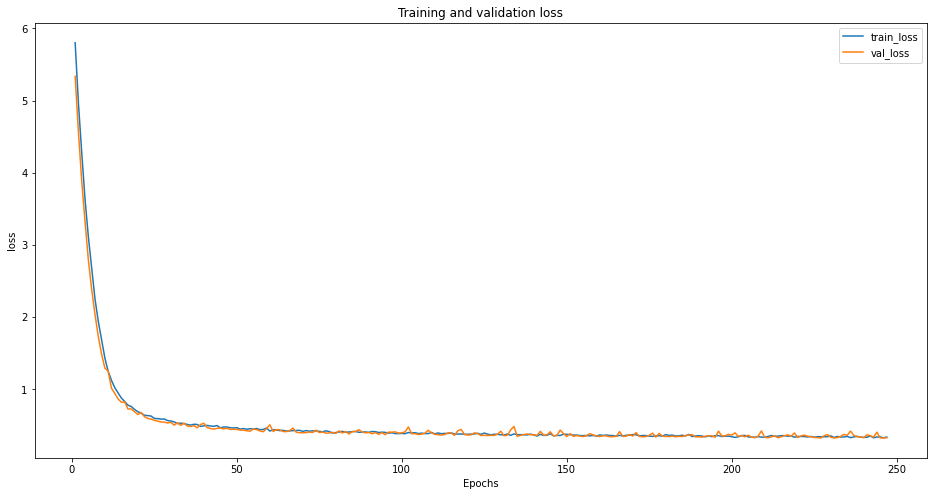

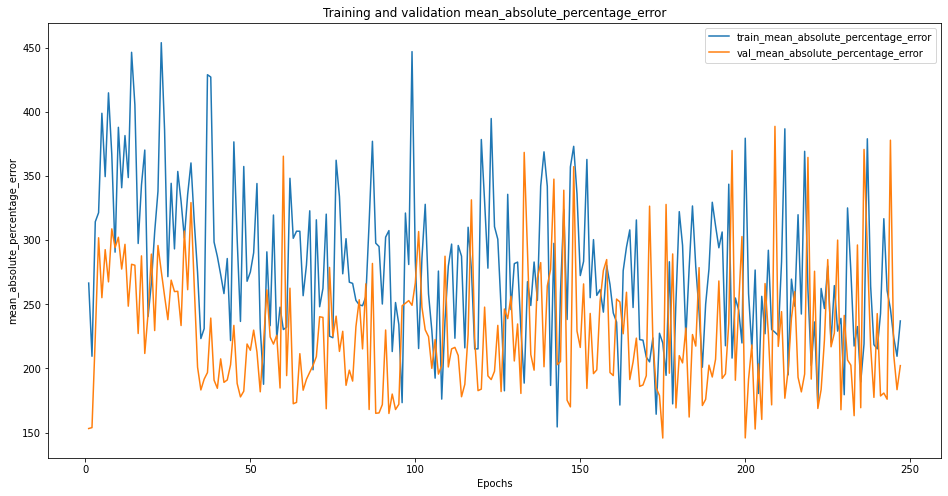

(None, None)

In [ ]:
plot_metric(history, 'loss'),plot_metric(history, 'mean_absolute_percentage_error')

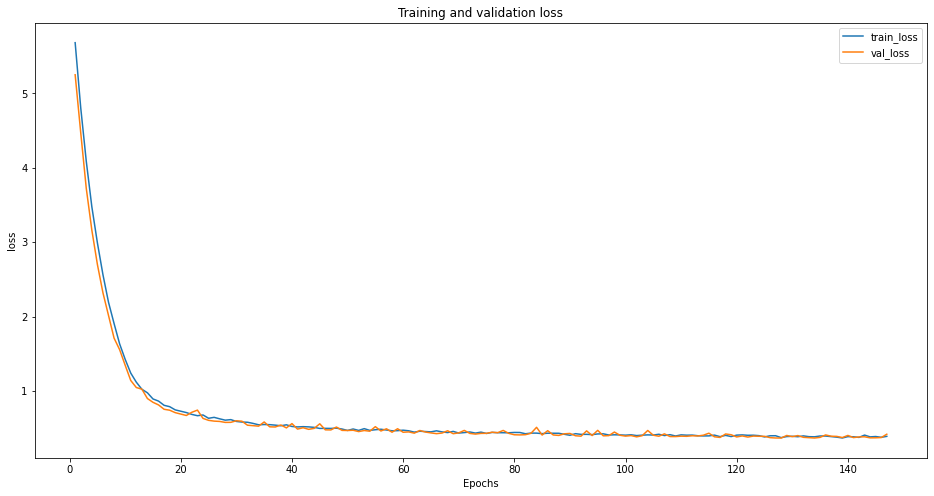

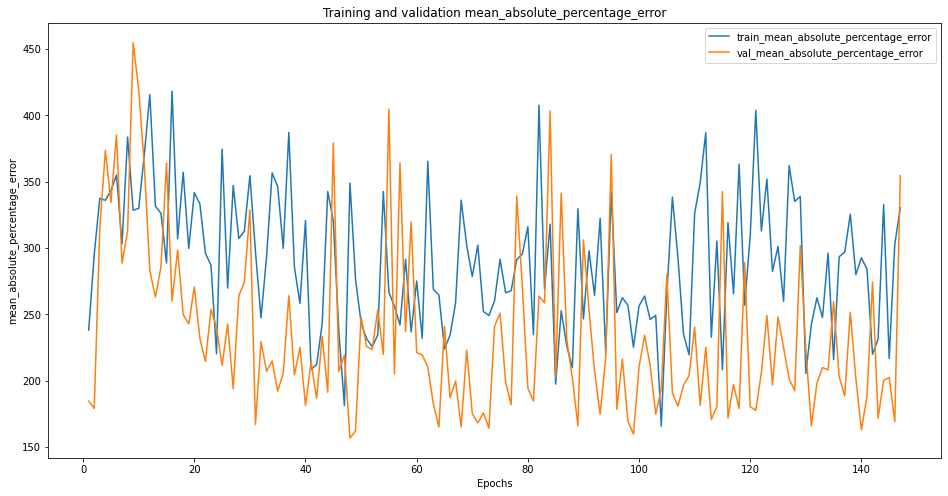

(None, None)

In [ ]:
plot_metric(history, 'loss'),plot_metric(history, 'mean_absolute_percentage_error')

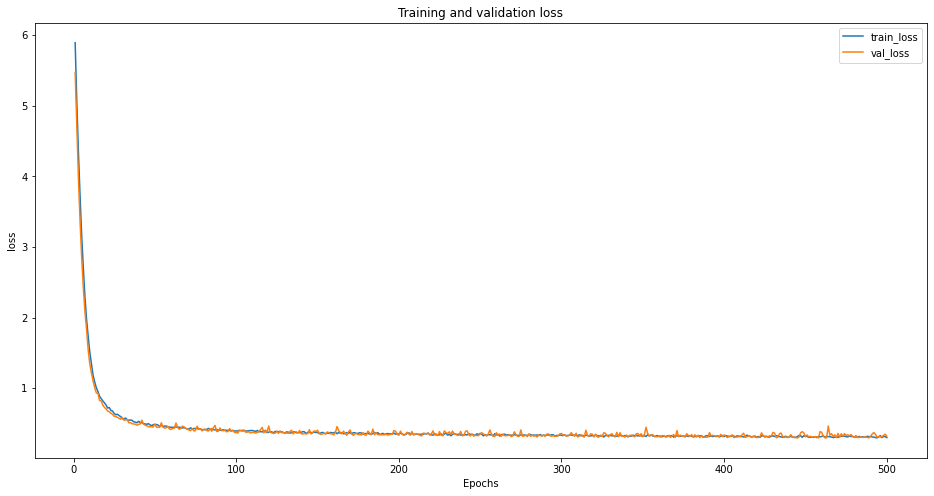

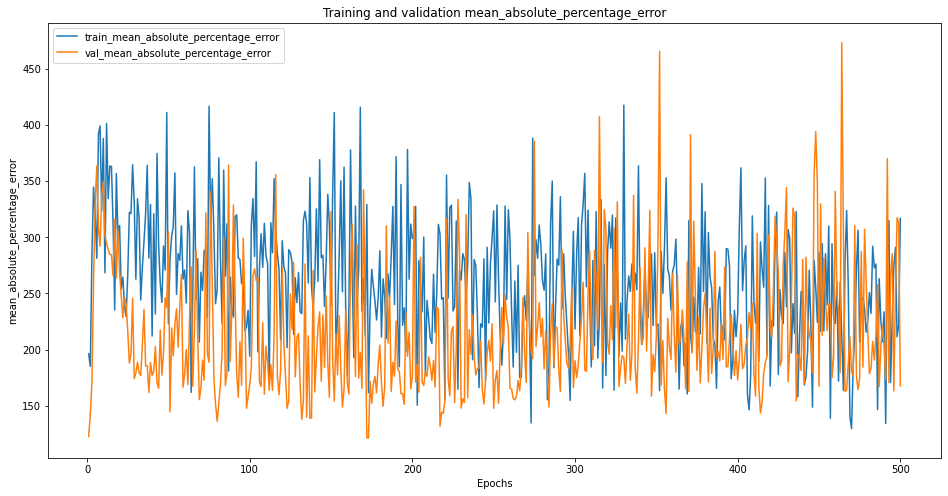

(None, None)

In [ ]:
plot_metric(history, 'loss'),plot_metric(history, 'mean_absolute_percentage_error')

In [ ]:
pred_on_v = scores(ml,x_val)
from sklearn.metrics import r2_score
r2_score(y_val,pred_on_v)

0.8680580429953493

In [ ]:
def func_easy(NUM_SAMPLES):
  X = np.random.uniform(0., 1., NUM_SAMPLES)
  X = np.sort(X, axis=0)
  noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
  y = np.sin(2 * np.pi * X)  + noise
  df1 = pd.DataFrame({'x':X,'y': y})
  plt.plot(X, y, '-o', label='true')
  plt.show()
  return df1 

In [ ]:
def func_ok(number_of_samples):
  np.random.seed(42)
  x1 = np.random.uniform(-1.0,1.0,number_of_samples)
  x2 = np.random.uniform(-1.0,1.0,number_of_samples)
  noise = np.random.uniform(-0.1, 0.1,number_of_samples)
  y=np.exp(x1**2-x2**2) +noise
  x = np.linspace(-1,1,number_of_samples)
  df1 = pd.DataFrame({'x1':x1, 'x2': x2,'y': y})
  #plt.plot(y,c='g')
  #plt.figure(1,(16,10))
  #plt.scatter(x1,x2,c='b')
  #plt.show()
  return df1

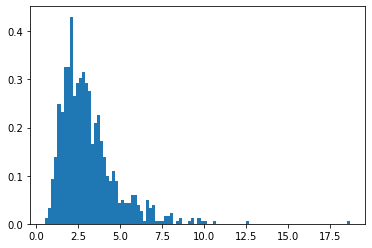

In [ ]:
number_of_samples=1000
a = np.random.lognormal(1,0.5,number_of_samples)
plt.hist(a, bins=100, density=True)
plt.show()

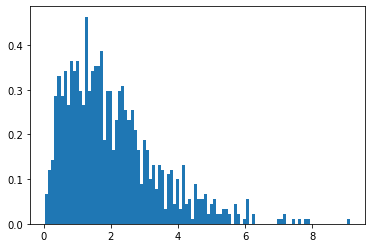

In [ ]:
c = np.random.gamma(2,1,(number_of_samples,))
plt.hist(c, bins=100, density=True)
plt.show()

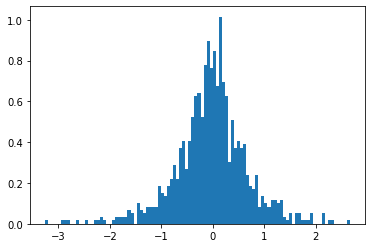

In [ ]:
b = np.random.uniform(-c/2,c/2,(number_of_samples,))
plt.hist(b, bins=100, density=True)
plt.show()

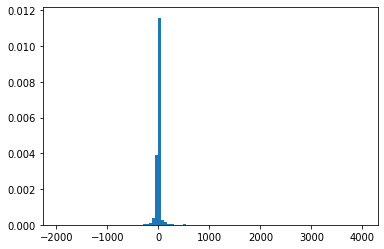

In [ ]:
noise = np.random.uniform(-0.1, 0.1,number_of_samples)
y = -0.36*a**3+0.93*a**2-0.69*b**2+0.89*b**3+0.45*np.exp(c)+0.5*noise
plt.hist(y, bins=100, density=True)
plt.show()

In [ ]:
def func_diff(number_of_samples):
  c = np.random.gamma(2,1,(number_of_samples,))
  a = np.random.lognormal(1,0.5,number_of_samples)
  b = np.random.uniform(-c,c,(number_of_samples,))
  noise = np.random.uniform(-0.1,0.1,(number_of_samples,))
  y = -0.36*a+0.93*a**2-0.69*b**2+0.89*b**3+0.45*np.exp(c/2)+0.5*noise
  df = pd.DataFrame({'a':a, 'b': b,'c': c,'y' : y})
  #sns.relplot(x='a',y='b',hue='y',data=df)
  #xrang = np.linspace(np.min(y), np.max(y),number_of_samples)
  #plt.figure(1,(16,10))
  #plt.scatter(xrang,y, c='r')
  #plt.plot(y)
  #plt.show()
  return df

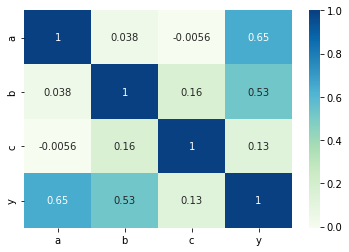

In [ ]:
df = func_diff(500)
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.GnBu)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["y"])
relevant_features = cor_target[cor_target>0]
relevant_features

In [ ]:
print(df.var())

a      2.485602
b      2.152281
c      1.912876
y    978.718699
dtype: float64


In [ ]:
def kde_plot(df,n_params):
  fig, axs = plt.subplots(1, n_params, figsize=(20, 10),sharex=True)
  l = list(df.columns)
  for i in range(n_params):
    sns.pairplot(df[[l[i],'y']], diag_kind='kde')

[(-10.0, 20.0)]

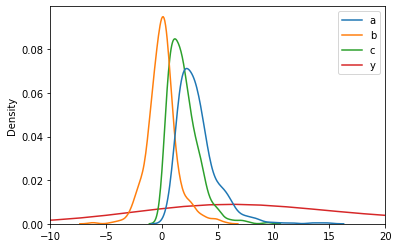

In [ ]:
g = sns.kdeplot(data = df)
g.set(xlim=(-10,20))

In [ ]:
def plot_dataset(df,sort=True):
    if sort:
        df.sort_values(by=['y'], inplace=True)
    plt.plot(df['y'].tolist(), label='expected')
    plt.show()
plot_dataset(df)

In [ ]:
def std_scalar(df):
  scalar = StandardScaler()
  X = scalar.fit_transform(df.values)
  df = pd.DataFrame(X,columns=df.columns)
  return  df

In [ ]:
def x_y_from_df(df):
  x_columns = df.columns.drop('y')
  x = df[x_columns].values
  y = df['y'].values
  return x, y 

In [ ]:
df,v = std_scalar(df)
x,y = x_y_from_df(df)

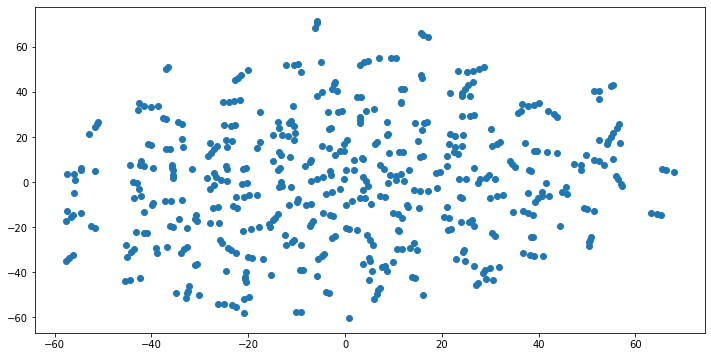

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5)
X_2d = tsne.fit_transform(x[:500])
plt.figure(figsize=(12, 6))
plt.scatter(X_2d[:,0], X_2d[:,1])

In [ ]:
X, x_val, Y, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [ ]:
x_train.shape, x_val.shape, X.shape, Y.shape, x_test.shape

((315, 3), (50, 3), (450, 3), (450,), (135, 3))

In [ ]:
##nn
def create_nn_model(input_dm):
  # Build the neural network
  model = Sequential()
  model.add(Dense(16, input_dim=input_dm, activation='relu')) # Hidden 1
  model.add(Dropout(0.1))
  model.add(Dense(12, activation='relu')) # Hidden 2
  model.add(Dense(1)) # Output
  #print(model.summary())
  return model

In [ ]:
def Compile(model):
  optimizer =Adam(0.1)
  model.compile(
      optimizer=optimizer, #Learning rate defaults to 0.1
      loss='mean_squared_error'
      )
  return model 

In [ ]:
def scores(model, x_test):
  # Predict
  pred = model.predict(x_test)
  return pred 

In [ ]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    plt.figure(1,(16,10))
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.subplot(221)
    plt.plot(t['y'].tolist(), c='b',label='expected')
    plt.plot(t['pred'].tolist(),c='g',label='prediction')
    xrang = np.linspace(np.min(y), np.max(y),len(y))
    plt.xlabel('Number of Test Samples')
    plt.ylabel('F(X)')
    plt.subplot(222)
    plt.scatter(xrang,t['y'].tolist(), c='b',label='expected')
    plt.scatter(xrang,t['pred'].tolist(), c='g',label='prediction')
    plt.ylabel('F(X)')
    plt.xlabel('Number of Test Samples')
    plt.legend()
    plt.show()

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(figsize=(16,8))
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
def create_rbf(n_of_clusters):
  # creating RBF network
  rbfLayer = rbflayer.RBFLayer(n_of_clusters,initializer=kmeans_initializer.InitCentersKMeans(x),betas=1.0,input_shape=(x.shape[1],))

  model = Sequential()
  model.add(rbfLayer)
  model.add(Dense(1, use_bias=True))
  return model

In [ ]:
rbf_model = create_rbf(5)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=20, verbose=1,mode='auto', 
                        restore_best_weights=True)
Compile(rbf_model)
rbf_his = rbf_model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=1000, batch_size=50,callbacks=[monitor])

In [ ]:
nn_model = create_nn_model(3)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=20, verbose=1,mode='auto', 
                        restore_best_weights=True)
Compile(nn_model)
nn_his = nn_model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=1000, batch_size=50,callbacks=[monitor])

In [ ]:
pred_nn = scores(nn_model, x_test)
pred_rbf = scores(rbf_model, x_test)

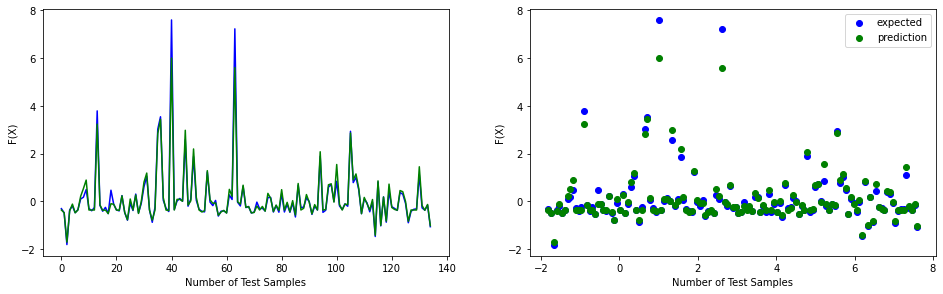

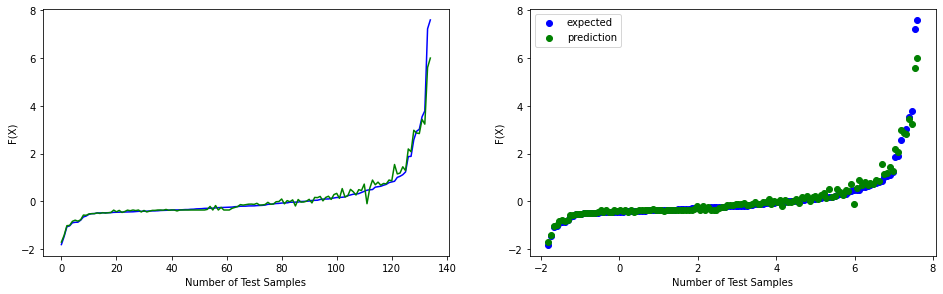

(None, None)

In [ ]:
chart_regression(pred_nn.flatten(), y_test, sort=False), chart_regression(pred_nn.flatten(), y_test) 

In [ ]:
pred_nn_cv = scores(nn_model, x_val, y_val)
pred_rbf_cv = scores(rbf_model, x_val, y_val)

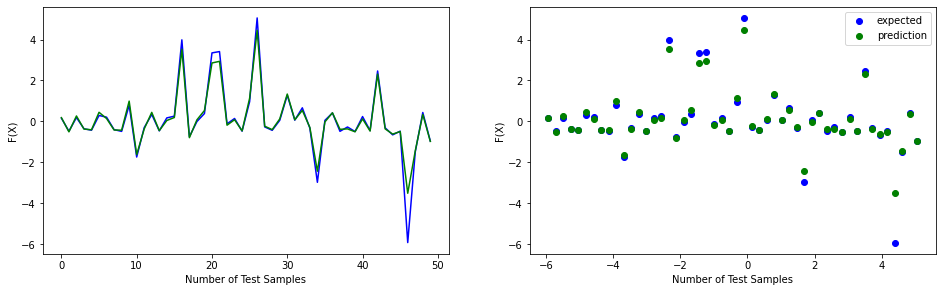

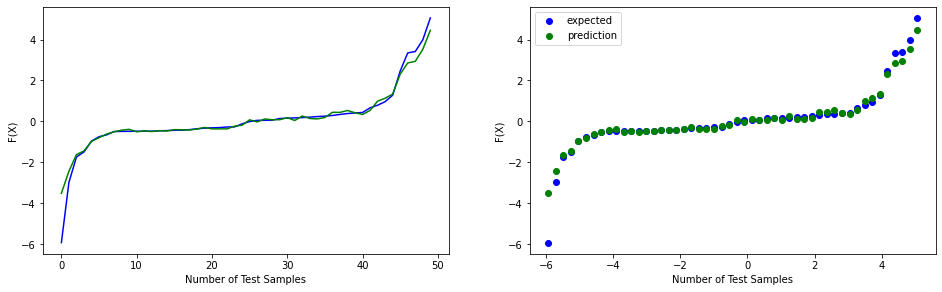

(None, None)

In [ ]:
chart_regression(pred_nn_cv.flatten(), y_val, sort=False), chart_regression(pred_nn_cv.flatten(), y_val) 

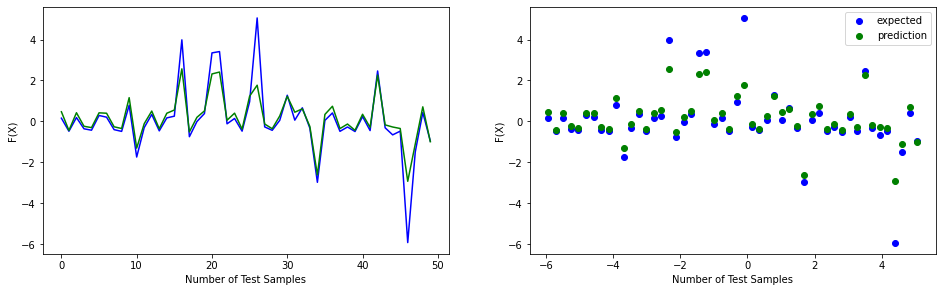

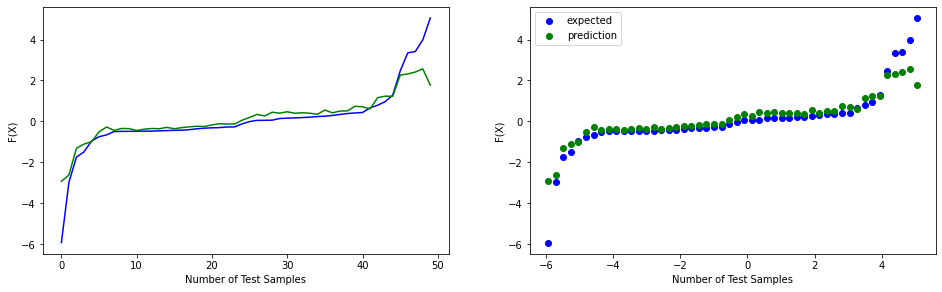

(None, None)

In [ ]:
chart_regression(pred_rbf_cv.flatten(), y_val, sort=False), chart_regression(pred_rbf_cv.flatten(), y_val) 

In [ ]:
plot_metric(nn_his,'loss'), plot_metric(rbf_his,'loss')

In [ ]:
### What about R^2 value 
def R_squared(y_test, pred):
  pred = pred.reshape(-1)
  y_hat = (np.sum(y_test))/len(y_test)
  return 1-(np.sum((y_test-pred)**2)/(np.sum((y_test-y_hat)**2)))
def my_mse(y_test,pred):
  n = len(y_test)
  return 1/n*np.sum((y_test-pred.reshape(-1))**2)
print("NN R_Squared = {},MSE = {}\nRBF R_Squared = {},MSE = {}".format(R_squared(y_test, pred_nn),my_mse(y_test, pred_nn),R_squared(y_test, pred_rbf),my_mse(y_test, pred_rbf)))

NN R_Squared = 0.9603646002606426,MSE = 0.0579217811017536
RBF R_Squared = 0.5644306765099327,MSE = 0.6365257112514648


In [ ]:
##Cross Check whether it works or not 
from sklearn.metrics import r2_score
nn, rbf = r2_score(y_test, pred_nn), r2_score(y_test, pred_rbf)
print(nn, rbf)

0.9603646002606426 0.5644306765099327


In [ ]:
#Copied from Scores() 
#Measure MSE error.  
  score = metrics.mean_squared_error(y_test, pred)
  print("Final score (MSE): {}".format(score))

  # Measure RMSE error.  RMSE is common for regression.
  score = np.sqrt(metrics.mean_squared_error(y_test, pred))
  print("Final score (RMSE): {}".format(score))

  ### Measures mean absolute percentage Errror 
  score = np.mean(np.abs((y_test - pred) / y_test)) * 100
  print("Final(MAPE): {}".format(score))

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def func_mape(y_test, pred):
  pred = pred.reshape(-1)
  mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
  return mape

training_samples = [100,200,300,400,500,600,700,1000,1500,2000,2500,3000]
def val_loss_vs_training_samples(training_samples):
  mse = []
  mape = []
  r_squared = []

  for i in training_samples:
    ###Get Function to be approximated and Data Set 
    df = func_diff(i)
    df = std_scalar(df)
    x,y = x_y_from_df(df)
    ####Test Train split 
    X, x_val, Y, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

    ##Create Model and compile 
    model = create_nn_model(x_train.shape[1])
    model = Compile(model)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                            patience=50, verbose=1,mode='auto', 
                            restore_best_weights=True)

    ###Model Fitting 
    hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=1000, batch_size=50,callbacks=[monitor])

    ## Plot Loss Vs Epochs 
    plot_metric(hist,'loss')

    
    pred_on_test = scores(model, x_test) ## Test Scores 
    pred_on_v = scores(model, x_val)

    mse.append([mean_squared_error(y_test, pred_on_test),mean_squared_error(y_val, pred_on_v)])
    mape.append([func_mape(y_test, pred_on_test),func_mape(y_val, pred_on_v)])
    r_squared.append([r2_score(y_test, pred_on_test),r2_score(y_val, pred_on_v)])
  return mse, mape, r_squared

In [ ]:
mse,map,r_2 = val_loss_vs_training_samples(training_samples)

In [ ]:
mse_n = np.array(mse)
map_n = np.array(map)
r_2_n = np.array(r_2)
list_of_y = [mse_n, map_n, r_2_n]

In [ ]:
def plot_tranings(training_samples, lis_of_y):
  plt.figure(figsize=(20,8))
  for j,i in enumerate(list_of_y):
    plt.subplot(1,3,j+1)
    plt.plot(training_samples,i[:,0],c='g',label='Test_data')
    plt.plot(training_samples,i[:,1],c='y',label='val_data')
    plt.xlabel("Number of Training Samples")
    plt.ylabel('Error')
    plt.legend(["On_Test", 'On_Val'])
  plt.show()

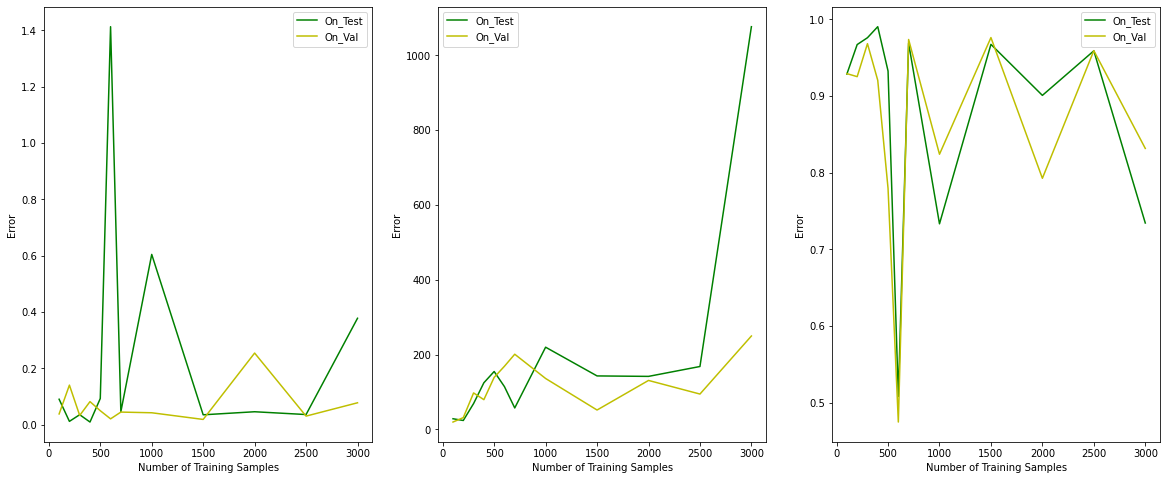

In [ ]:
plot_tranings(training_samples, list_of_y)

In [ ]:
### How to check Variance of different Model 
def _draw_bootstrap_sample(rng, X, y, frac = 1.0):
    """
    Function to draw a single bootstrap sub-sample from given data.
    Use frac to adjust the size of the sample as a fraction of data. Defaults to size of given data.
    """
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(sample_indices,
                                   size=int(sample_indices.shape[0] * frac),
                                   replace=True)
    return X[bootstrap_indices], y[bootstrap_indices]  


def bias_variance_decomp(estimator, X_train, y_train, X_test, y_test,
                         loss='0-1_loss', num_rounds=200, random_seed=42, bootstrap_frac = 1.0, 
                         single_sample=False, single_sample_index=0):
    """
    Extended from: mlxtend library (URL:http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/)
    
    Function to generate "num_rounds" realizations of the given ML estimator using bootstrap sub-samples.
    """
    supported = ['mse']
    if loss not in supported:
        raise NotImplementedError('loss must be one of the following: %s' %
                                  supported)

    rng = np.random.RandomState(random_seed)

    # Array with predictions of all test set observations for "num_round" bootstrap sub-samples
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.int)

    for i in range(num_rounds):
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train, frac = bootstrap_frac)
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Only if "single_sample" is set to True
    # A slice of "all_pred" to get predictions of a single observation from "all_pred"
    # Provide observation index in "single_sample_index
    single_sample_estimates = None
        # This is in the case of regression model whose outcomes are a continuous real value.
    avg_expected_loss = np.apply_along_axis(
            lambda x:
            ((x - y_test)**2).mean(),
            axis=1,
            arr=all_pred).mean()

    main_predictions = np.mean(all_pred, axis=0)

    avg_bias = np.sum((main_predictions - y_test)**2) / y_test.size
    avg_var = np.sum((main_predictions - all_pred)**2) / all_pred.size

    single_sample_estimates = np.zeros(num_rounds)
    if single_sample == True:
        single_sample_estimates = all_pred[:,single_sample_index]

    return avg_expected_loss, avg_bias, avg_var, all_pred, single_sample_estimates

In [ ]:
import pandas as pd
import os
import numpy as np
import time
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam

def generate_model(dropout, neuronPct, neuronShrink):
    # We start with some percent of 5000 starting neurons on 
    # the first hidden layer.
    neuronCount = int(neuronPct * 100)
    
    # Construct neural network
    model = Sequential()

    # So long as there would have been at least 25 neurons and 
    # fewer than 10
    # layers, create a new layer.
    layer = 0
    while neuronCount>25 and layer<10:
        # The first (0th) layer needs an input input_dim(neuronCount)
        if layer==0:
            model.add(Dense(neuronCount, 
                input_dim=x.shape[1], 
                activation=PReLU()))
        else:
            model.add(Dense(neuronCount, activation=PReLU())) 
        layer += 1

        # Add dropout after each hidden layer
        model.add(Dropout(dropout))

        # Shrink neuron count for each layer
        neuronCount = neuronCount * neuronShrink

    model.add(Dense(1,activation='softmax')) # Output
    return model

In [ ]:
# Generate a model and see what the resulting structure looks like.
model = generate_model(dropout=0.2, neuronPct=0.1, neuronShrink=0.25)
model.summary()

In [ ]:
def evaluate_network(dropout,lr,neuronPct,neuronShrink):
    SPLITS = 10

    # Bootstrap
    boot = KFold(n_splits=SPLITS, shuffle=True, random_state=42)

    # Track progress
    mean_benchmark = []
    epochs_needed = []
    num = 0
    
    ###VAriable NAme 
    X,Y = x, y 
    # Loop through samples
    for train, test in boot.split(X,Y):
        start_time = time.time()
        num+=1

        # Split train and test
        x_train = X[train]
        y_train = Y[train]
        x_test = X[test]
        y_test = Y[test]

        model = generate_model(dropout, neuronPct, neuronShrink)
        model.compile(loss='mean_squared_error', optimizer=Adam(lr==lr))
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=100, verbose=0, mode='auto', restore_best_weights=True)

        # Train on the bootstrap sample
        model.fit(x_train,y_train,validation_data=(x_test,y_test),
                  callbacks=[monitor],verbose=0,epochs=1000)
        epochs = monitor.stopped_epoch
        epochs_needed.append(epochs)

        # Predict on the out of boot (validation)
        pred = model.predict(x_test)

        # Measure this bootstrap's log loss
        score = metrics.mean_squared_error(y_test, pred)
        mean_benchmark.append(score)
        m1 = statistics.mean(mean_benchmark)
        m2 = statistics.mean(epochs_needed)
        mdev = statistics.pstdev(mean_benchmark)

        # Record this iteration
        time_took = time.time() - start_time
        
    tensorflow.keras.backend.clear_session()
    return (-m1)

In [ ]:
print(evaluate_network(dropout=0.2,lr=1e-3,neuronPct=0.2,neuronShrink=0.2))

-0.23142666595129138


In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=cd6edd23406e9fc186469246f6088b3f2f73f342055eafe88988010ec18905a4
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.0, 0.499),
           'lr': (0.0, 0.1),
           'neuronPct': (0.01, 0.5),
           'neuronShrink': (0.01, 1)
          }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=20,)
time_took = time.time() - start_time

print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

|   iter    |  target   |  dropout  |    lr     | neuronPct | neuron... |
-------------------------------------------------------------------------
|  1        | -0.2314   |  0.2081   |  0.07203  |  0.01006  |  0.3093   |
|  2        | -0.2314   |  0.07323  |  0.009234 |  0.1013   |  0.3521   |
|  3        | -0.2314   |  0.198    |  0.05388  |  0.2154   |  0.6884   |
|  4        | -0.2314   |  0.102    |  0.08781  |  0.02342  |  0.6738   |
|  5        | -0.2314   |  0.2082   |  0.05587  |  0.07879  |  0.2061   |
|  6        | -0.2314   |  0.3996   |  0.09683  |  0.1636   |  0.6954   |
|  7        | -0.2314   |  0.4373   |  0.08946  |  0.05167  |  0.04866  |
|  8        | -0.2314   |  0.08475  |  0.08781  |  0.05819  |  0.4269   |
|  9        | -0.2314   |  0.478    |  0.05332  |  0.349    |  0.3224   |
|  10       | -0.2314   |  0.3426   |  0.08346  |  0.01896  |  0.7526   |
|  11       | -0.2314   |  0.02431  |  0.0136   |  0.1765   |  0.6597   |
|  12       | -0.2314   |  0.2926   | 

In [ ]:
x.shape, y.shape

((500, 1), (500,))

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
m = LinearRegression()

In [ ]:
lr_model = m.fit(x_train, y_train)

In [ ]:
score = lr_model.score(x_test,y_test)

In [ ]:
lr_model.coef_, lr_model.intercept_

(array([-0.09506657, -0.06110297]), 1.1340018305953106)

In [ ]:
X = np.hstack([x, x**2, x**3])
X.shape

(1000, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

In [ ]:
normalizer = preprocessing.Normalization(axis=1)

In [ ]:
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

[[585.33673]]


In [ ]:
time = np.array(train_features['Time (sec)'])
bmp_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
bmp_normalizer.adapt(time)

bmp_normalizer.mean.numpy()

array([585.33673], dtype=float32)